###  Example of the coherence computation using conn_csd

In this notebook we use the autoregressive example model from [Dhamala et. al.](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.100.018701). The model consists of two coupled random variables ($2\rightarrow 1$), the coupling is time-varying therefore the coherence should detect the coupling dynamics. The model is given by the equations bellow:

$X_{1}(t) = 0.55X_{1}(t-1)-0.8X_{1}(t-2)+C(t)X_{2}(t-1)+\epsilon (t)$

$X_{2}(t) = 0.55X_{2}(t-1)-0.8X_{2}(t-2)+\xi (t)$

Here, $X_1(t)$ and $X_2(t)$ are $AR(2)$. The variable $t$ is the time step index,
such that the actual time is $t'=t\,\Delta t=t/f_{\rm s}$. Besides, we know by construction that
$X_2(t)$ influences $X_1(t)$ through the coupling constant $C$
(although the opposite does not happen). In the simulation $C(t)=0.25$ for $t<15$ s, and zero otherwise. 

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")
import itertools
import os
import time

import h5py
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import xarray as xr
from tqdm import tqdm
from xfrites.conn.conn_csd import conn_csd

import GDa.graphics.plot as plot

#### Defining function to simulate de model

In [2]:
def ar_model_dhamala(
    N=5000, Trials=10, Fs=200, C=0.2, t_start=0, t_stop=None, cov=None
):
    """
    AR model from Dhamala et. al.
    """

    T = N / Fs

    time = np.linspace(0, T, N)

    X = np.random.random([Trials, N])
    Y = np.random.random([Trials, N])

    def interval(t, t_start, t_stop):
        if t_stop == None:
            return t >= t_start
        else:
            return (t >= t_start) * (t <= t_stop)

    for i in tqdm(range(Trials)):
        E = np.random.multivariate_normal(np.zeros(cov.shape[0]), cov, size=(N,))
        for t in range(2, N):
            X[i, t] = (
                0.55 * X[i, t - 1]
                - 0.8 * X[i, t - 2]
                + interval(time[t], t_start, t_stop) * C * Y[i, t - 1]
                + E[t, 0]
            )
            Y[i, t] = 0.55 * Y[i, t - 1] - 0.8 * Y[i, t - 2] + E[t, 1]

    Z = np.zeros([Trials, 2, N])

    Z[:, 0, :] = X
    Z[:, 1, :] = Y

    return Z

Model parameters

In [3]:
N = 5000  # Number of observations
Fs = 200  # Sampling frequency
dt = 1.0 / Fs  # Time resolution
C = 0.25  # Coupling parameter
Trials = 100  # Number of trials
freqs = np.arange(1, 100, 1)  # Frequency axis
# Covariance matrix
cov = np.array([[1.00, 0.00], [0.00, 1.00]])

Generating data

In [4]:
# Generating data
X = ar_model_dhamala(N=N, Trials=Trials, C=C, Fs=Fs, t_start=0, t_stop=15, cov=cov)

100%|██████████████████████████| 100/100 [00:02<00:00, 41.95it/s]


In [5]:
X = xr.DataArray(
    X,
    dims=("trials", "roi", "times"),
    coords=(np.arange(Trials), ["X", "Y"], np.arange(N) / Fs),
)

### Measuring coherence

In [6]:
kw = dict(fmin=0, fmax=100, bandwidth=5)
csd = conn_csd(
    X,
    times="times",
    roi="roi",
    sfreq=Fs,
    mode="multitaper",
    freqs=None,
    verbose=None,
    n_jobs=20,
    csd_kwargs=kw,
)

Defining links (n_roi=2; directed=False; net=False, nb_min_links=None)
    Sorting roi names
/home/vinicius/.local/lib/python3.8/site-packages/mne/externals/tqdm/__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(__version__) < LooseVersion('4.36'):
/home/vinicius/.local/lib/python3.8/site-packages/mne/externals/tqdm/__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(__version__) < LooseVersion('4.36'):


  0%|          | Estimating CSD : 0/100 [00:00<?,       ?it/s]

#### Computing spectra

In [7]:
coh_xy = (
    np.abs(csd.sel(roi="X-Y")) ** 2 / (csd.sel(roi="X-X") * csd.sel(roi="Y-Y"))
).real

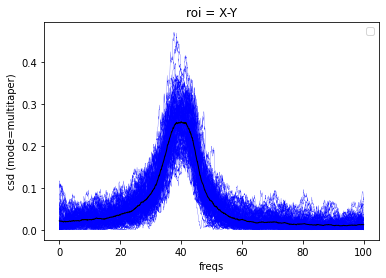

In [8]:
coh_xy.plot(x="freqs", hue="trials", color="b", lw=0.2)
coh_xy.mean("trials").plot(x="freqs", hue="trials", color="k", lw=1)
plt.legend([])

In [9]:
kw = dict(fmin=0, fmax=100, bandwidth=5)
coh = conn_csd(
    X,
    times="times",
    roi="roi",
    sfreq=Fs,
    mode="multitaper",
    metric="ipc",
    freqs=None,
    n_jobs=20,
    verbose=None,
    csd_kwargs=kw,
)

Defining links (n_roi=2; directed=False; net=False, nb_min_links=None)
    Sorting roi names


  0%|          | Estimating CSD : 0/100 [00:00<?,       ?it/s]

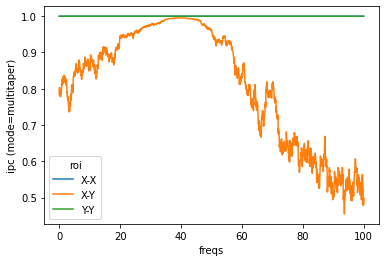

In [13]:
np.abs(coh).plot(x="freqs", hue="roi")

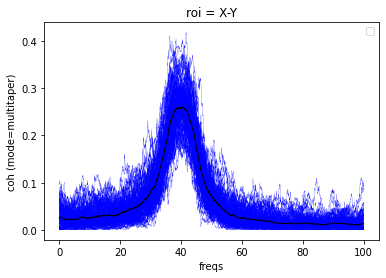

In [10]:
coh.isel(roi=0).real.plot(x="freqs", hue="trials", color="b", lw=0.2)
coh.isel(roi=0).real.mean("trials").plot(x="freqs", hue="trials", color="k", lw=1)
plt.legend([])

In [11]:
import argparse
import os
import time

import numpy as np
from frites.conn.conn_spec import conn_spec

from config import (
    decim,
    freqs,
    mode,
    n_cycles,
    return_evt_dt,
    sessions,
    sm_freqs,
    sm_kernel,
    sm_times,
)
from GDa.session import session
from GDa.signal.surrogates import trial_swap_surrogates

In [12]:
#  Instantiating session
ses = session(
    raw_path="/home/vinicius/storage1/projects/GrayData-Analysis/GrayLab/",
    monkey="lucy",
    date="141017",
    session=1,
    slvr_msmod=True,
    align_to="cue",
    evt_dt=[-0.65, 3],
)
# Load data
ses.read_from_mat()

In [57]:
kw = dict(fmin=3, fmax=80, bandwidth=10, n_fft=None)
coh = conn_csd(
    ses.data.sel(time=slice(1, 1.4)),
    times="time",
    roi="roi",
    sfreq=1000,
    mode="multitaper",
    metric="coh",
    freqs=None,
    n_jobs=20,
    verbose=None,
    csd_kwargs=kw,
)

Defining links (n_roi=94; directed=False; net=False, nb_min_links=None)
    Sorting roi names


  0%|          | Estimating CSD : 0/595 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=4371, n_freqs=30)


  0%|          |  : 0/4371 [00:00<?,       ?it/s]

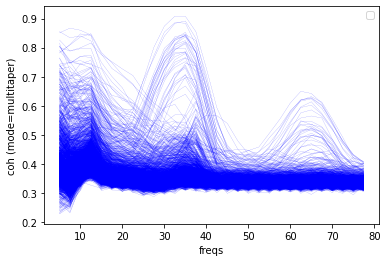

In [58]:
coh.mean("trials").plot(x="freqs", hue="roi", color="b", lw=0.1)
# coh.mean("trials").isel(roi=0).mean("trials").plot(x="freqs", hue="roi", color="k", lw=1);
plt.legend([])